In [4]:
from sklearn.datasets import fetch_species_distributions
import numpy as np
data = fetch_species_distributions()


In [49]:
species_names = [name.decode() for name in np.unique(data.train['species'])]
target_species = 'microryzomys_minutus'

# Filter training points for the chosen species
train_mask = [name.decode() == target_species for name in data.train['species']]
X_train_coords = np.c_[data.train['dd long'], data.train['dd lat']][train_mask]
y_train = np.ones(X_train_coords.shape[0])  # all present

# Randomly sample background points (absence), e.g. from the environmental grid
n_absences = X_train_coords.shape[0]
grid_x, grid_y = np.meshgrid(
    np.linspace(data.x_left_lower_corner, data.x_left_lower_corner + data.grid_size * data.Nx, data.Nx),
    np.linspace(data.y_left_lower_corner, data.y_left_lower_corner + data.grid_size * data.grid_size * data.Ny, data.Ny)
)
absences_coords = np.array([grid_x.flatten(), grid_y.flatten()]).T[np.random.choice(grid_x.size, n_absences, replace=False)]
y_absence = np.zeros(n_absences)

# Combine presences and absences for training
X_train = np.vstack([X_train_coords, absences_coords])
y_train = np.concatenate([y_train, y_absence])


print('X_train shape:', X_train.shape)
print('y_train ones:', (y_train == 1).sum())
print('y_train zeros:', (y_train == 0).sum())
print('Unique species:', species_names)
print('First few presence coords:', X_train_coords[:5])
print('First few absence coords:', absences_coords[:5])



X_train shape: (176, 2)
y_train ones: 88
y_train zeros: 88
Unique species: ['bradypus_variegatus', 'bradypus_variegatus_0', 'bradypus_variegatus_1', 'bradypus_variegatus_2', 'bradypus_variegatus_3', 'bradypus_variegatus_4', 'bradypus_variegatus_5', 'bradypus_variegatus_6', 'bradypus_variegatus_7', 'bradypus_variegatus_8', 'bradypus_variegatus_9', 'microryzomys_minutus', 'microryzomys_minutus_0', 'microryzomys_minutus_1', 'microryzomys_minutus_2', 'microryzomys_minutus_3', 'microryzomys_minutus_4', 'microryzomys_minutus_5', 'microryzomys_minutus_6', 'microryzomys_minutus_7', 'microryzomys_minutus_8', 'microryzomys_minutus_9']
First few presence coords: [[-64.7    -17.85  ]
 [-67.8333 -16.3333]
 [-67.8833 -16.3   ]
 [-67.8    -16.2667]
 [-67.9833 -15.9   ]]
First few absence coords: [[-40.80545004 -53.08313639]
 [-37.50272502 -53.66350094]
 [-55.96796036 -54.14630421]
 [-91.847564   -55.12191703]
 [-78.2863749  -55.30203017]]


In [50]:
def get_env_features(coords, coverages, x_ll, y_ll, grid_size):
    """
    Given coordinates and coverage data, extract environmental features for each point.
    Skips coordinates that fall outside grid bounds.

    Args:
        coords (np.ndarray): N x 2 array of [longitude, latitude] (shape: [N, 2])
        coverages (np.ndarray): Environment data array (shape: [n_features, Ny, Nx])
        x_ll (float): Longitude of grid's lower-left corner
        y_ll (float): Latitude of grid's lower-left corner
        grid_size (float): Grid cell size (degrees)

    Returns:
        tuple: (np.ndarray, np.ndarray) - N x n_features array of environmental features, indices of valid points
    """
    envs = []
    valid_indices = []
    Ny, Nx = coverages.shape[1], coverages.shape[2]
    for i, (lon, lat) in enumerate(coords):
        ix = int((lon - x_ll) / grid_size)
        iy = int((lat - y_ll) / grid_size)
        if 0 <= ix < Nx and 0 <= iy < Ny:
            vals = coverages[:, iy, ix]
            # Replace -9999 (missing data) with np.nan if present
            vals = np.where(vals == -9999, np.nan, vals)
            envs.append(vals)
            valid_indices.append(i)
    return np.array(envs), np.array(valid_indices)

In [51]:
X_train_env, train_valid_indices = get_env_features(
    X_train, data.coverages,
    data.x_left_lower_corner, data.y_left_lower_corner, data.grid_size
)
X_train_filtered = X_train[train_valid_indices]
y_train_filtered = y_train[train_valid_indices]

print("Environmental features for training shape:", X_train_env.shape)
print("Filtered X_train shape:", X_train_filtered.shape)
print("Filtered y_train shape:", y_train_filtered.shape)

Environmental features for training shape: (176, 14)
Filtered X_train shape: (176, 2)
Filtered y_train shape: (176,)


In [52]:
# Mask and extract coords for a label with test samples
target_species = 'bradypus_variegatus_0'  # or any label with valid test points
test_mask = [name.decode() == target_species for name in data.test['species']]
X_test_coords = np.c_[data.test['dd long'], data.test['dd lat']][test_mask]
y_test = np.ones(X_test_coords.shape[0])

X_test_env, test_valid_indices = get_env_features(
    X_test_coords, data.coverages,
    data.x_left_lower_corner, data.y_left_lower_corner, data.grid_size
)
# Explicitly cast indices to integer type
test_valid_indices = test_valid_indices.astype(int)

X_test_filtered = X_test_coords[test_valid_indices]
y_test_filtered = y_test[test_valid_indices]

print("Environmental features for test shape:", X_test_env.shape)
print("Filtered X_test shape:", X_test_filtered.shape)
print("Filtered y_test shape:", y_test_filtered.shape)

Environmental features for test shape: (35, 14)
Filtered X_test shape: (35, 2)
Filtered y_test shape: (35,)


In [55]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

# Train
clf = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)
clf.fit(X_train_env, y_train_filtered)

# Predict and Evaluate
if X_test_env.shape[0] > 0:
    y_pred = clf.predict_proba(X_test_env)[:, 1]

    # Evaluate
    if len(np.unique(y_test_filtered)) > 1:
        print("AUC:", roc_auc_score(y_test_filtered, y_pred))
    else:
        print("AUC cannot be calculated: Only one class present in y_test_filtered.")
else:
    print("No test points within the grid for the target species. Cannot predict or calculate AUC.")

AUC cannot be calculated: Only one class present in y_test_filtered.


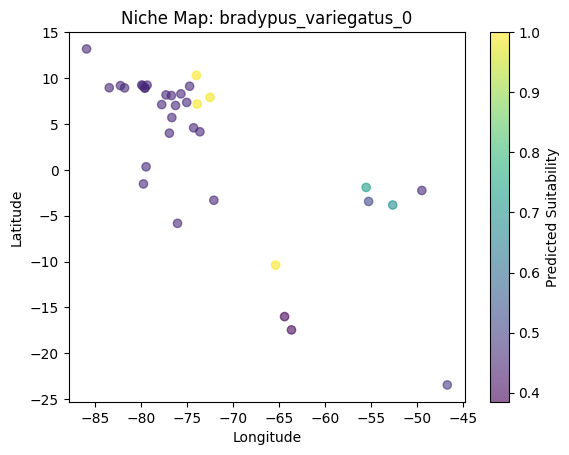

In [56]:
import matplotlib.pyplot as plt

plt.scatter(X_test_coords[:,0], X_test_coords[:,1], c=y_pred, cmap='viridis', alpha=0.6)
plt.colorbar(label='Predicted Suitability')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'Niche Map: {target_species}')
plt.show()
